# Model Setup



---

## Overview
This notebook is for setting up a simple CNN-LSTM model to predict event-wise hurricane intensity using the prreproceesed data from the `era5_preprocessing.ipynb` notebook. 

1. **Data Preparation**: Load and preprocess the data.
2. **Model Definition**: Define a CNN-LSTM model.
3. **Model Training**: Train the model on the prepared data.    

## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to NUMPY](https://foundations.projectpythia.org/core/numpy/) | Necessary | |
| [Intro to PANDAS](https://foundations.projectpythia.org/core/numpy/) | Necessary | |
| [Intro to XARRAY](https://foundations.projectpythia.org/core/xarray/) | Necessary | |
| [Intro to TensorFlow](https://foundations.projectpythia.org/core/tensorflow/) | Necessary | |
| Project management | Helpful | |

- **Time to learn**: estimate in minutes. For a rough idea, use 5 mins per subsection, 10 if longer; add these up for a total. Safer to round up and overestimate.
- **System requirements**:
    - Populate with any system, version, or non-Python software requirements if necessary
    - Otherwise use the concepts table above and the Imports section below to describe required packages as necessary
    - If no extra requirements, remove the **System requirements** point altogether

---

## Imports


In [54]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xarray as xr


from sklearn.preprocessing import MinMaxScaler


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.layers import  TimeDistributed, LSTM
import visualkeras
import tensorflow as tf


## Load the hurricane wise variable dataset

In this section,we will load the preprocessed dataset containing hurricane-wise environmental variables. This dataset is essential for training our CNN-LSTM model to predict hurricane intensity.


In [16]:
# load the preprocessed dataset
model_input = xr.open_dataset('../test_folder/input_predictands.nc')
model_input


FileNotFoundError: [Errno 2] No such file or directory: b'/Users/nalex2023/main/ml-hurricane-intensity/test_folder/input_predictands.nc'

### Input Data prerpocessing steps
- Nan and padded values will be set to zero
- Set the train and test split
- normalize using the MinMaxScaler
- random shuffle for generalization


In [ ]:
# remove the nan values and set it 
model_input = model_input.fillna(0)

# selecting the predictors (X) and expanding the dimensions

X_data = model_input[['u','v','vo','speed_shear','sp','r','cor_params']].to_array(dim='variable')

print(f'Dimensions are , features: {X_data.shape[0]}, Event: {X_data.shape[1]}, time(lead): {X_data.shape[2]}, lat: {X_data.shape[3]}, lon: {X_data.shape[4]}')

X_data = X_data.transpose('id', 'lead', 'y','x','variable')

print(f'X_data dimensions are: Event: {X_data.shape[0]}, time(lead): {X_data.shape[1]}, lat: {X_data.shape[2]}, lon: {X_data.shape[3]}, features: {X_data.shape[4]}')

In [34]:
# selecting the target variable (y)
Y_data = model_input['target']

# expanded the dimensions of Y_data to match the expected input shape for the model
#Y_data = np.expand_dims(Y_data, axis=-1)

print(f'Target dimensions are: Event: {Y_data.shape[0]}, time(lead): {Y_data.shape[1]}')

Target dimensions are: Event: 69, time(lead): 80


In [36]:
## 80% train and 20% test split

## random shuffled the events and split the data into training and testing sets
X_train , X_test , Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=1)


X_train_data = X_train.values
X_test_data = X_test.values
Y_train_data = Y_train.values
Y_test_data = Y_test.values




In [38]:
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()

y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

In [39]:
X_train_scaled = x_train_scaler.fit_transform(X_train_data.reshape(-1, X_train_data.shape[-1])).reshape(X_train_data.shape)
Y_train_scaled = y_train_scaler.fit_transform(Y_train_data.reshape(-1,1)).reshape(Y_train_data.shape)

X_test_scaled = x_test_scaler.fit_transform(X_test_data.reshape(-1, X_test_data.shape[-1])).reshape(X_test_data.shape)
Y_test_scaled = y_test_scaler.fit_transform(Y_test_data.reshape(-1,1)).reshape(Y_test_data.shape)


In [42]:
def masked_mse(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, 0.0), tf.float32)
    squared_error = tf.square(y_true - y_pred)
    masked_loss = tf.reduce_sum(squared_error * mask) / (tf.reduce_sum(mask) + 1e-6)
    return masked_loss

model = Sequential()
model.add(TimeDistributed(
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    input_shape=(140, 5, 5, 7)
))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(64, return_sequences=True))  # <--- important!
model.add(TimeDistributed(Dense(1)))

model.summary()


/Users/nalex2023/miniconda3/envs/nma/lib/python3.12/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 140, 5, 5, 16)  │         1,024 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 140, 400)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 140, 64)        │       119,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 140, 1)         │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,129 (469.25 KB)

 Trainable params: 120,129 (469.25 KB)

 Non-trainable params: 0 (0.00 B)

/Users/nalex2023/miniconda3/envs/nma/lib/python3.12/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


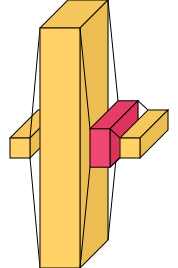

In [51]:
visualkeras.layered_view(model,scale_xy=0.6)


In [56]:
model.compile(optimizer='adam', metrics=['mae'] , loss=masked_mse)

model.fit(X_train_scaled, Y_train_scaled, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 741ms/step - loss: 0.2514 - mae: 0.1917 - val_loss: 0.3028 - val_mae: 0.5903
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.2703 - mae: 0.5623 - val_loss: 0.0283 - val_mae: 0.3295
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0517 - mae: 0.3204 - val_loss: 0.0857 - val_mae: 0.2005
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0922 - mae: 0.1916 - val_loss: 0.0894 - val_mae: 0.2032
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0983 - mae: 0.2047 - val_loss: 0.0296 - val_mae: 0.2532
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0388 - mae: 0.2608 - val_loss: 0.0204 - val_mae: 0.3254
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0335 - mae: 0.3409 - val_loss: 0.0404 - val_mae: 0.3826
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0486 - mae: 0.3913 - val_loss: 0.0433 - val_mae: 0.3891
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0469 - mae:

In [57]:
predict_x = model.predict(X_test_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


In [100]:
def invert_add_meta(data,scalar,xr_data):
    data = scalar.inverse_transform(data.reshape(-1 ,1)).reshape(xr_data.shape)
    added_meta = xr.DataArray(data, coords=xr_data.coords, dims=xr_data.dims)
    return added_meta

predicted_wind_speed = invert_add_meta(predict_x, y_test_scaler, Y_test)

observed_wind_speeds = Y_test

final_dset = predicted_wind_speed.to_dataset(name='predicted_wind_speed')
final_dset['observed_wind_speed'] = observed_wind_speeds
                                                    
final_dft = final_dset.to_dataframe().reset_index()

# set 0.0 as nan in observed_wind_speed
final_dft['observed_wind_speed'] = final_dft['observed_wind_speed'].replace(0.0, np.nan)

# whenever the predicted_wind_speed is nan, sdrop the entire row

final_dft = final_dft.dropna(how='any',axis=0)

final_pivot_col = final_dft.drop(columns=['time','level'])

/var/folders/bt/kswp83jx5mj4bn1bjkh9g4rsg_b7ks/T/ipykernel_45613/3932672332.py:12: UserWarning: 
The palette list has fewer values (6) than needed (14) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(
/var/folders/bt/kswp83jx5mj4bn1bjkh9g4rsg_b7ks/T/ipykernel_45613/3932672332.py:25: UserWarning: 
The palette list has fewer values (6) than needed (14) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


Text(0.5, 1.0, 'Predicted (Reds) vs Observed Wind Speed (Blues)')

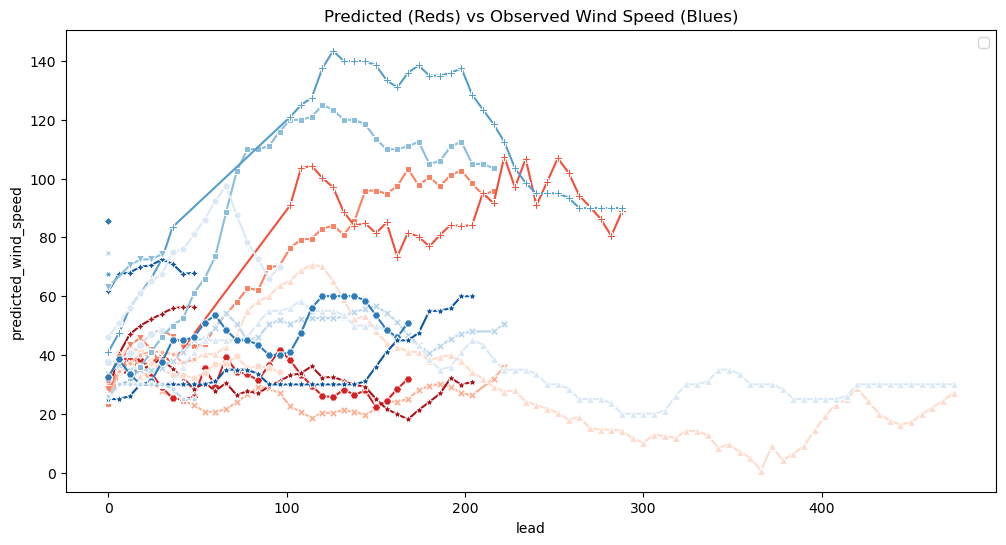

In [115]:
import seaborn as sbs 

import seaborn as sns
import matplotlib.pyplot as plt

# Define two different palettes
palette1 = sns.color_palette("Reds")           # for predicted
palette2 = sns.color_palette("Blues")            # for observed

fig,ax = plt.subplots(figsize=(12, 6))
# First lineplot (predicted) with palette1
sns.lineplot(
    data=final_pivot_col,
    x='lead',
    y='predicted_wind_speed',
    hue='id',
    style='id',
    markers=True,
    dashes=False,
    palette=palette1,
    legend='brief'
,ax=ax)

# Second lineplot (observed) with palette2
sns.lineplot(
    data=final_pivot_col,
    x='lead',
    y='observed_wind_speed',
    hue='id',
    style='id',
    markers=True,
    dashes=False,
    palette=palette2,
    legend='brief'
,ax=ax)
plt.legend('')

ax.set_title('Predicted (Reds) vs Observed Wind Speed (Blues)')
#sbs.lineplot(data=final_pivot_col, x='lead', y='observed_wind_speed', hue='id', style='id', markers=True, dashes=False)

Check out [**any number of helpful Markdown resources**](https://www.markdownguide.org/basic-syntax/) for further customizing your notebooks and the [**MyST Syntax Overview**](https://mystmd.org/guide/syntax-overview) for MyST-specific formatting information. Don't hesitate to ask questions if you have problems getting it to look *just right*.

## Last Section

You can add [admonitions using MyST syntax](https://mystmd.org/guide/admonitions):

:::{note}
Your relevant information here!
:::

Some other admonitions you can put in ([there are 10 total](https://mystmd.org/guide/admonitions#admonitions-list)):

:::{hint}
A helpful hint.
:::

:::{warning}
Be careful!
:::

:::{danger}
Scary stuff be here.
:::

We also suggest checking out Jupyter Book's [brief demonstration](https://jupyterbook.org/content/metadata.html#jupyter-cell-tags) on adding cell tags to your cells in Jupyter Notebook, Lab, or manually. Using these cell tags can allow you to [customize](https://jupyterbook.org/interactive/hiding.html) how your code content is displayed and even [demonstrate errors](https://jupyterbook.org/content/execute.html#dealing-with-code-that-raises-errors) without altogether crashing our loyal army of machines!

---

## Summary
Add one final `---` marking the end of your body of content, and then conclude with a brief single paragraph summarizing at a high level the key pieces that were learned and how they tied to your objectives. Look to reiterate what the most important takeaways were.

### What's next?
Let Jupyter book tie this to the next (sequential) piece of content that people could move on to down below and in the sidebar. However, if this page uniquely enables your reader to tackle other nonsequential concepts throughout this book, or even external content, link to it here!

## Resources and references
Finally, be rigorous in your citations and references as necessary. Give credit where credit is due. Also, feel free to link to relevant external material, further reading, documentation, etc. Then you're done! Give yourself a quick review, a high five, and send us a pull request. A few final notes:
 - `Kernel > Restart Kernel and Run All Cells...` to confirm that your notebook will cleanly run from start to finish
 - `Kernel > Restart Kernel and Clear All Outputs...` before committing your notebook, our machines will do the heavy lifting
 - Take credit! Provide author contact information if you'd like; if so, consider adding information here at the bottom of your notebook
 - Give credit! Attribute appropriate authorship for referenced code, information, images, etc.
 - Only include what you're legally allowed: **no copyright infringement or plagiarism**
 
Thank you for your contribution!